In [ ]:
import pandas as pd


In [18]:
df = pd.read_pickle("merged_df_with_clusters.pkl")

In [19]:
df.head()

,message_id,conversation_id,text,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,self_ref_freq,self_ref_ratio,second_person_freq,second_person_ratio,token_count,expressive_label,anthropomorphic_label,summary,domain_topic,task_types,domain_topic_clusters,task_types_clusters
0,008UbdD_0_0,008UbdD_0,What specifically did the California Judge rul...,0.000,0.947,0.053,0.128,0.0,0.0,0.0,0.0,30.0,0.0,0.0,Request a legal brief on the California Judge'...,"[Law, Constitutional Law, Proposition 22]","[analysis, writing]","[29, 47]","[9, 14]"
1,00B9jFM_0_0,00B9jFM_0,give me some python,0.000,1.000,0.000,0.000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Request Python resources or examples.,"[programming, Python]","[request, information gathering]","[12, 49]","[3, 4]"
2,00B9jFM_0_2,00B9jFM_0,Give me a javascript code to calculate Fibonacci,0.000,1.000,0.000,0.000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Request JavaScript code to calculate Fibonacci...,"[programming, JavaScript, algorithms]","[coding, implementation]","[12, 22, 49]","[0, 13]"
3,00BdXPA_0_0,00BdXPA_0,define AI,0.000,1.000,0.000,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Define artificial intelligence.,"[artificial intelligence, technology]","[definition, explanation]",[45],"[0, 2]"
4,00BdXPA_0_2,00BdXPA_0,what are the components for problem formulatio...,0.155,0.747,0.098,-0.250,0.0,0.0,0.0,0.0,15.0,0.0,0.0,Identify components for problem formulation in...,"[AI, Data Science, Problem Formulation]","[analysis, planning]","[3, 30, 40]","[7, 9]"


In [21]:
print(df.head())


    message_id conversation_id  \
0  008UbdD_0_0       008UbdD_0   
1  00B9jFM_0_0       00B9jFM_0   
2  00B9jFM_0_2       00B9jFM_0   
3  00BdXPA_0_0       00BdXPA_0   
4  00BdXPA_0_2       00BdXPA_0   

                                                text  neg_sentiment  \
0  What specifically did the California Judge rul...          0.000   
1                                give me some python          0.000   
2   Give me a javascript code to calculate Fibonacci          0.000   
3                                          define AI          0.000   
4  what are the components for problem formulatio...          0.155   

   neu_sentiment  pos_sentiment  compound_sentiment  self_ref_freq  \
0          0.947          0.053               0.128            0.0   
1          1.000          0.000               0.000            1.0   
2          1.000          0.000               0.000            1.0   
3          1.000          0.000               0.000            0.0   
4          0.747  

In [27]:
import pandas as pd
import numpy as np
from scipy import stats

def analyze_cluster_significance(df, cluster_info_df, metric_col, alpha=0.05):
    """
    Test if each cluster's mean is significantly different from overall mean
    """
    # Calculate overall mean
    overall_mean = df[metric_col].mean()
    print(f"Overall mean for {metric_col}: {overall_mean:.3f}")
    
    # Get top 20 clusters by occurrence from cluster_info_df
    top_clusters = cluster_info_df.head(20)
    
    results = []
    for _, cluster_row in top_clusters.iterrows():
        # Extract cluster number from 'Cluster' column (remove 'C' prefix)
        cluster_num = int(cluster_row['Cluster'].replace('C', ''))
        
        # Get all messages belonging to this cluster
        cluster_messages = df[df['domain_topic_clusters'].apply(lambda x: cluster_num in x)]
        cluster_values = cluster_messages[metric_col]
        
        if len(cluster_values) > 0:
            # Calculate statistics
            n = len(cluster_values)
            mean = cluster_values.mean()
            std = cluster_values.std()
            sem = std / np.sqrt(n)
            
            # Perform one-sample t-test
            t_stat, p_value = stats.ttest_1samp(cluster_values, overall_mean)
            
            # Calculate confidence interval
            ci_lower, ci_upper = stats.t.interval(1-alpha, n-1, loc=mean, scale=sem)
            
            results.append({
                'Cluster': cluster_row['Cluster'],
                'Sample_Size': n,
                'Mean': mean,
                'Std': std,
                'SEM': sem,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                't_statistic': t_stat,
                'p_value': p_value,
                'Significant': p_value < alpha,
                'Effect': 'Higher' if mean > overall_mean else 'Lower' if mean < overall_mean else 'Same',
                'Diff_from_Overall': mean - overall_mean
            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Mean', ascending=False)
    
    # Format for display
    display_df = results_df[['Cluster', 'Sample_Size', 'Mean', 'Diff_from_Overall', 
                            'SEM', 'p_value', 'Significant', 'Effect']]
    display_df = display_df.round({
        'Mean': 3, 
        'Diff_from_Overall': 3, 
        'SEM': 4, 
        'p_value': 4
    })
    
    return display_df

# Read cluster info
cluster_info = pd.read_csv('clustering_results/domain_clusters_detailed.csv')

# Analyze each metric
metrics = ['compound_sentiment', 'expressive_label', 'anthropomorphic_label']

for metric in metrics:
    print(f"\nAnalysis for {metric}:")
    results = analyze_cluster_significance(df, cluster_info, metric)
    print("\nResults sorted by mean value:")
    print(results)
    
    # Print summary of significant differences
    sig_results = results[results['Significant']]
    print(f"\nNumber of significantly different clusters: {len(sig_results)}")
    print("\nClusters with largest differences:")
    print(sig_results.head(5)[['Cluster', 'Mean', 'Diff_from_Overall', 'p_value']])


Analysis for compound_sentiment:
Overall mean for compound_sentiment: 0.182

Results sorted by mean value:
   Cluster  Sample_Size   Mean  Diff_from_Overall     SEM  p_value  \
10     C35        17705  0.384              0.203  0.0031   0.0000   
15      C1        14096  0.310              0.128  0.0036   0.0000   
18     C45        17200  0.246              0.064  0.0031   0.0000   
7      C40        22713  0.229              0.047  0.0030   0.0000   
8      C20        22929  0.220              0.038  0.0025   0.0000   
16     C19        18155  0.214              0.032  0.0029   0.0000   
11     C13        21018  0.214              0.032  0.0028   0.0000   
2      C48        35104  0.212              0.031  0.0022   0.0000   
9      C18        21059  0.209              0.028  0.0031   0.0000   
17     C22        14740  0.201              0.020  0.0031   0.0000   
6      C30        26246  0.201              0.019  0.0022   0.0000   
19      C6        12176  0.198              0.016  0

In [29]:
# check unique values in  expressive_label	anthropomorphic_label	
df['expressive_label'].unique()
df['anthropomorphic_label'].unique()



array([ 0.,  1., nan])

In [30]:
import pandas as pd
import numpy as np
from scipy import stats

def analyze_metric_significance(df, cluster_info_df, metric_col, alpha=0.05):
    """
    Analyze significance using appropriate tests based on metric type
    """
    # Calculate overall statistics
    overall_mean = df[metric_col].mean()
    print(f"Overall mean for {metric_col}: {overall_mean:.3f}")
    
    # Check if metric is binary (0/1)
    is_binary = df[metric_col].isin([0, 1, 0.0, 1.0, np.nan]).all()
    
    # Get top 20 clusters
    top_clusters = cluster_info_df.head(20)
    
    results = []
    for _, cluster_row in top_clusters.iterrows():
        cluster_num = int(cluster_row['Cluster'].replace('C', ''))
        cluster_messages = df[df['domain_topic_clusters'].apply(lambda x: cluster_num in x)]
        cluster_values = cluster_messages[metric_col]
        
        if len(cluster_values) > 0:
            n = len(cluster_values)
            mean = cluster_values.mean()
            
            if is_binary:
                # For binary metrics, use chi-square test
                observed = np.array([
                    [sum(cluster_values == 1), sum(cluster_values == 0)],
                    [(df[metric_col] == 1).sum() - sum(cluster_values == 1),
                     (df[metric_col] == 0).sum() - sum(cluster_values == 0)]
                ])
                chi2, p_value = stats.chi2_contingency(observed)[:2]
                test_stat = chi2
            else:
                # For continuous metrics, use t-test
                std = cluster_values.std()
                sem = std / np.sqrt(n)
                t_stat, p_value = stats.ttest_1samp(cluster_values, overall_mean)
                test_stat = t_stat
            
            results.append({
                'Cluster': cluster_row['Cluster'],
                'Sample_Size': n,
                'Mean': mean,
                'Overall_Mean': overall_mean,
                'Test_Statistic': test_stat,
                'p_value': p_value,
                'Significant': p_value < alpha,
                'Effect': 'Higher' if mean > overall_mean else 'Lower',
                'Diff_from_Overall': mean - overall_mean
            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Mean', ascending=False)
    
    # Format for display
    display_df = results_df[['Cluster', 'Sample_Size', 'Mean', 'Diff_from_Overall', 
                            'p_value', 'Significant', 'Effect']]
    display_df = display_df.round({
        'Mean': 3, 
        'Diff_from_Overall': 3, 
        'p_value': 4
    })
    
    return display_df

# Analyze metrics
metrics = ['compound_sentiment', 'expressive_label', 'anthropomorphic_label']

for metric in metrics:
    print(f"\nAnalysis for {metric}:")
    results = analyze_metric_significance(df, cluster_info, metric)
    print("\nResults sorted by mean value:")
    print(results)
    
    # Print summary of significant differences
    sig_results = results[results['Significant']]
    print(f"\nNumber of significantly different clusters: {len(sig_results)}")
    print("\nClusters with largest differences:")
    print(sig_results.head(5)[['Cluster', 'Mean', 'Diff_from_Overall', 'p_value']])


Analysis for compound_sentiment:
Overall mean for compound_sentiment: 0.182

Results sorted by mean value:
   Cluster  Sample_Size   Mean  Diff_from_Overall  p_value  Significant  \
10     C35        17705  0.384              0.203   0.0000         True   
15      C1        14096  0.310              0.128   0.0000         True   
18     C45        17200  0.246              0.064   0.0000         True   
7      C40        22713  0.229              0.047   0.0000         True   
8      C20        22929  0.220              0.038   0.0000         True   
16     C19        18155  0.214              0.032   0.0000         True   
11     C13        21018  0.214              0.032   0.0000         True   
2      C48        35104  0.212              0.031   0.0000         True   
9      C18        21059  0.209              0.028   0.0000         True   
17     C22        14740  0.201              0.020   0.0000         True   
6      C30        26246  0.201              0.019   0.0000         


Expressive Messages Analysis:
                     Labeled  Non-labeled
compound_sentiment     0.323        0.158
self_ref_ratio         0.036        0.018
second_person_ratio    0.029        0.016
token_count           92.004       60.116

Anthropomorphic Messages Analysis:
                     Labeled  Non-labeled
compound_sentiment     0.265        0.159
self_ref_ratio         0.035        0.017
second_person_ratio    0.055        0.008
token_count           73.528       62.348


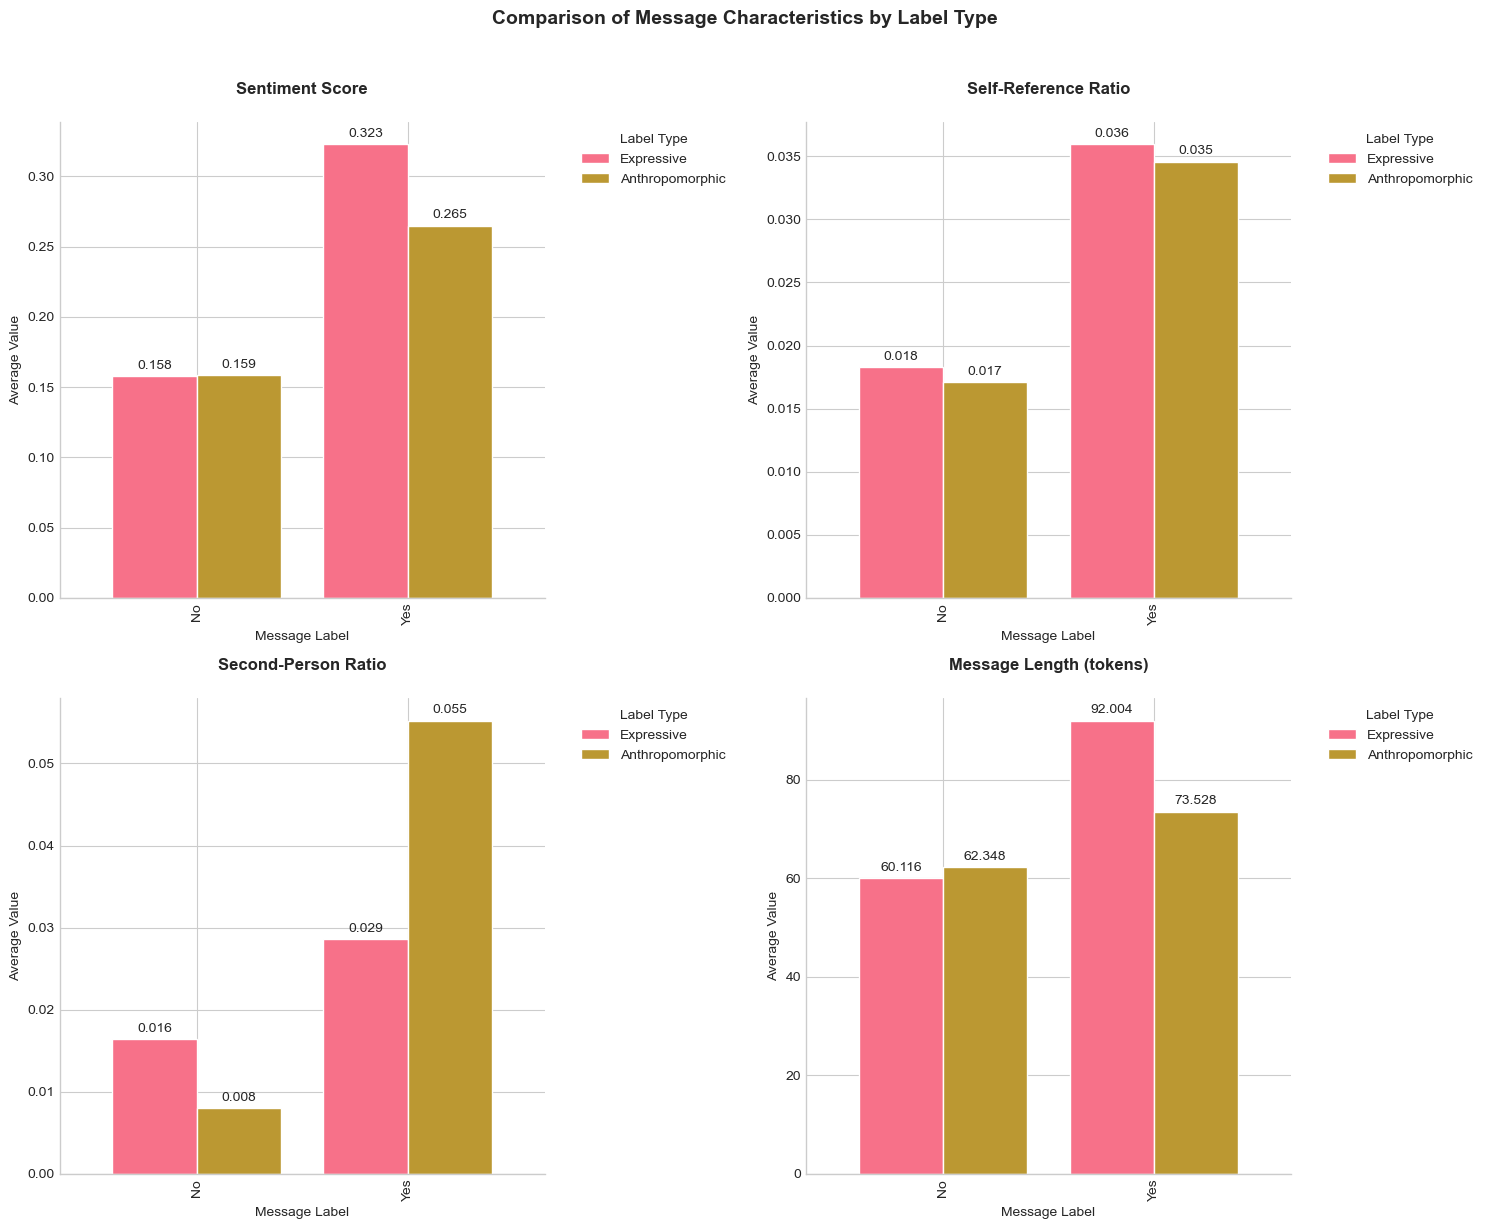

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-colorblind')
sns.set_palette("husl")

# Analyze both labels
def analyze_labeled_messages(df, label_col, metrics):
    labeled = df[df[label_col] == 1]
    non_labeled = df[df[label_col] == 0]
    
    metrics_comparison = pd.DataFrame({
        'Labeled': [labeled[m].mean() for m in metrics],
        'Non-labeled': [non_labeled[m].mean() for m in metrics]
    }, index=metrics)
    
    return metrics_comparison

# Set up metrics and their display names
metrics = {
    'compound_sentiment': 'Sentiment Score',
    'self_ref_ratio': 'Self-Reference Ratio',
    'second_person_ratio': 'Second-Person Ratio',
    'token_count': 'Message Length (tokens)'
}

# Get results
expr_results = analyze_labeled_messages(df, 'expressive_label', metrics.keys())
anthr_results = analyze_labeled_messages(df, 'anthropomorphic_label', metrics.keys())

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Plot each metric
for idx, (metric, title) in enumerate(metrics.items()):
    data = pd.DataFrame({
        'Expressive': [expr_results.loc[metric, 'Non-labeled'], 
                      expr_results.loc[metric, 'Labeled']],
        'Anthropomorphic': [anthr_results.loc[metric, 'Non-labeled'], 
                           anthr_results.loc[metric, 'Labeled']]
    }, index=['No', 'Yes'])
    
    ax = axes[idx]
    data.plot(kind='bar', ax=ax, width=0.8)
    
    # Customize each subplot
    ax.set_title(title, pad=20, fontsize=12, fontweight='bold')
    ax.set_xlabel('Message Label', fontsize=10)
    ax.set_ylabel('Average Value', fontsize=10)
    
    # Add value labels on bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.3f', padding=3)
    
    # Customize legend
    ax.legend(title='Label Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove top and right spines
    sns.despine(ax=ax)

# Adjust layout
plt.suptitle('Comparison of Message Characteristics by Label Type', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Print summary statistics
print("\nExpressive Messages Analysis:")
print(expr_results.round(3))
print("\nAnthropomorphic Messages Analysis:")
print(anthr_results.round(3))


Summary Statistics:
Metric                 compound_sentiment  second_person_ratio  \
Type            Label                                            
Anthropomorphic No                  0.159                0.008   
                Yes                 0.265                0.055   
Expressive      No                  0.158                0.016   
                Yes                 0.323                0.029   

Metric                 self_ref_ratio  token_count  
Type            Label                               
Anthropomorphic No              0.017       62.348  
                Yes             0.035       73.528  
Expressive      No              0.018       60.116  
                Yes             0.036       92.004  


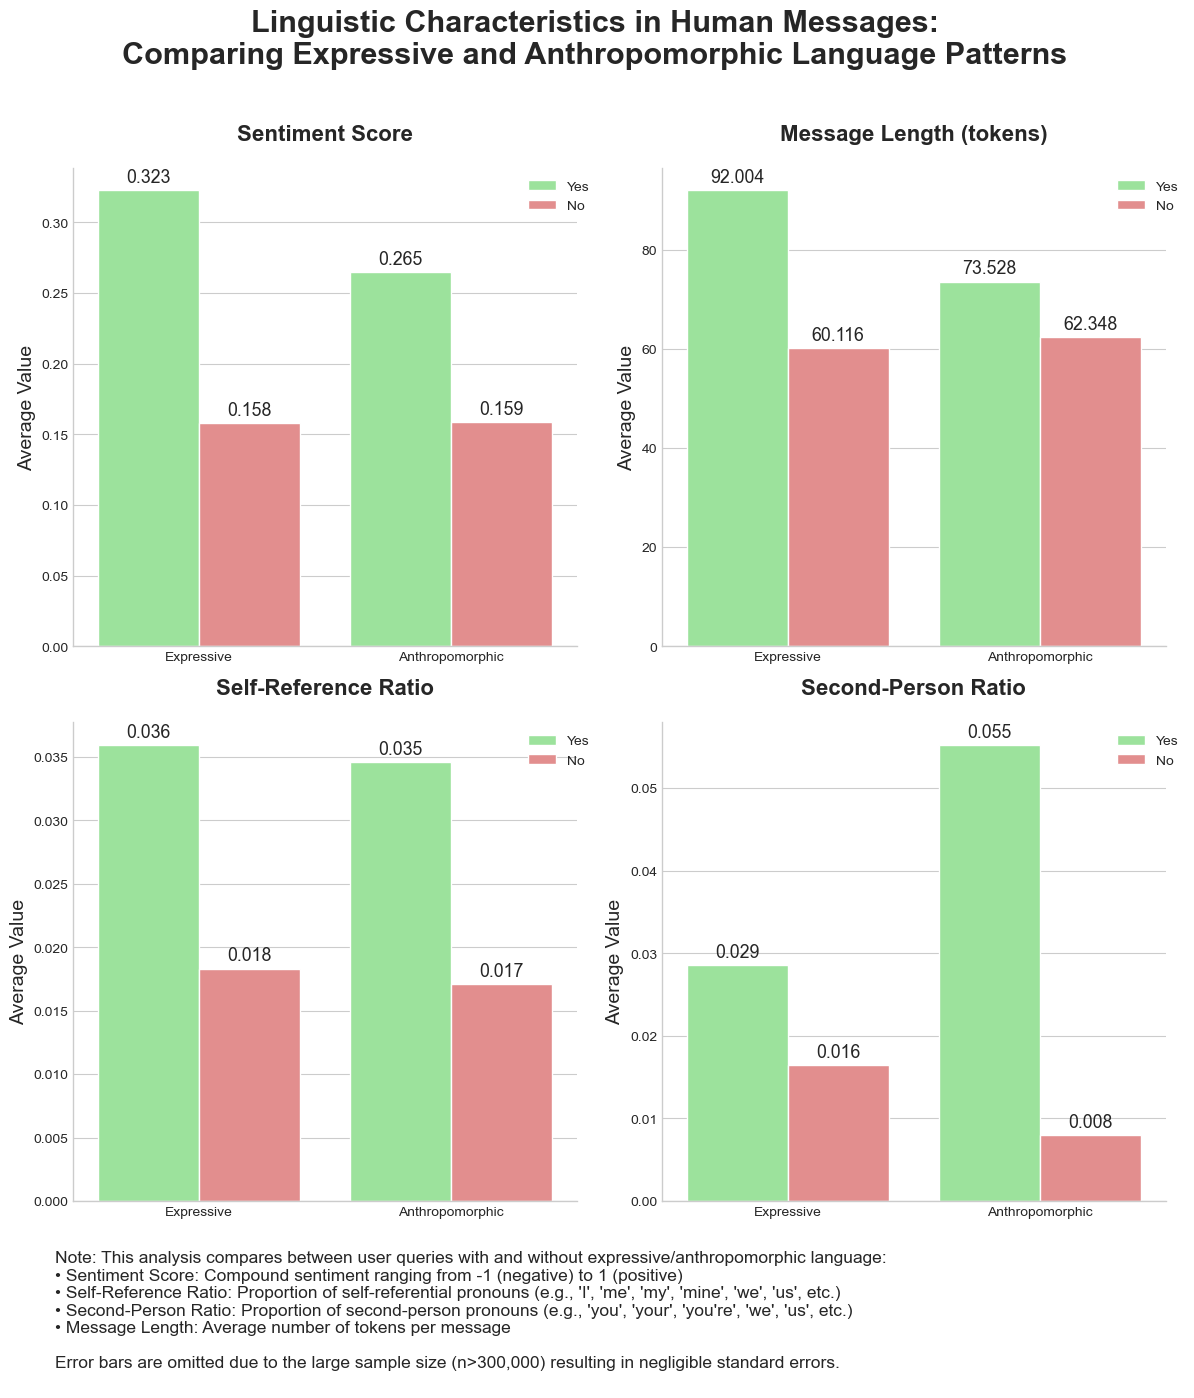

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-colorblind')
sns.set_palette("husl")

# Analyze both labels
def analyze_labeled_messages(df, label_col, metrics):
    labeled = df[df[label_col] == 1]
    non_labeled = df[df[label_col] == 0]
    
    metrics_comparison = pd.DataFrame({
        'Value': [labeled[m].mean() for m in metrics] + [non_labeled[m].mean() for m in metrics],
        'Label': ['Yes'] * len(metrics) + ['No'] * len(metrics),
        'Metric': list(metrics) * 2,
        'Type': [label_col.replace('_label', '').title()] * (len(metrics) * 2)
    })
    
    return metrics_comparison

# Set up metrics and their display names
metrics = {
    'compound_sentiment': 'Sentiment Score',
    'token_count': 'Message Length (tokens)',
    'self_ref_ratio': 'Self-Reference Ratio',
    'second_person_ratio': 'Second-Person Ratio'
    
}

# Get results and combine
expr_results = analyze_labeled_messages(df, 'expressive_label', metrics.keys())
anthr_results = analyze_labeled_messages(df, 'anthropomorphic_label', metrics.keys())
all_results = pd.concat([expr_results, anthr_results])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

# Plot each metric
for idx, (metric, title) in enumerate(metrics.items()):
    metric_data = all_results[all_results['Metric'] == metric]
    
    # Create grouped bar plot
    sns.barplot(
        data=metric_data,
        x='Type',
        y='Value',
        hue='Label',
        ax=axes[idx],
        palette=['lightgreen','lightcoral']
    )
    
    # Customize each subplot
    axes[idx].set_title(title, pad=20, fontsize=16, fontweight='bold')
    axes[idx].set_xlabel('')  # Remove x-label as it's redundant
    axes[idx].set_ylabel('Average Value', fontsize=14)
    
    # Add value labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.3f', padding=3, fontsize=12.8)
    
    # Customize legend
    # if idx == 0:  # Only keep one legend
    axes[idx].legend(bbox_to_anchor=(1.05, 1))
    # else:
    #     axes[idx].get_legend().remove()
    
    # Remove top and right spines
    sns.despine(ax=axes[idx])

plt.suptitle('Linguistic Characteristics in Human Messages:\nComparing Expressive and Anthropomorphic Language Patterns', 
             fontsize=22, fontweight='bold', y=1.02)

# Add explanatory notes
note_text = """
Note: This analysis compares between user queries with and without expressive/anthropomorphic language:
• Sentiment Score: Compound sentiment ranging from -1 (negative) to 1 (positive)
• Self-Reference Ratio: Proportion of self-referential pronouns (e.g., 'I', 'me', 'my', 'mine', 'we', 'us', etc.)
• Second-Person Ratio: Proportion of second-person pronouns (e.g., 'you', 'your', 'you\'re', 'we', 'us', etc.)
• Message Length: Average number of tokens per message

Error bars are omitted due to the large sample size (n>300,000) resulting in negligible standard errors.
"""

fig.text(0.05, 0, note_text, fontsize=12.5, ha='left', va='top', wrap=True)

plt.tight_layout()

# Print summary statistics
print("\nSummary Statistics:")
pivot_table = all_results.pivot_table(
    values='Value', 
    index=['Type', 'Label'], 
    columns='Metric', 
    aggfunc='first'
).round(3)
print(pivot_table)


Top 20 distinctive words for Expressive:

Distinctive for Expressive = Yes:
writing: 790.5460
storytelling: 670.8157
communication: 603.6902
literature: 557.5305
creative writing: 502.6984
character development: 465.3993
content creation: 356.4512
fiction: 215.0085
fantasy: 203.4256
philosophy: 177.2133
education: 175.5653
psychology: 140.5340
editing: 115.4939
gaming: 93.2113
personal development: 93.0335
creativity: 92.4011
character interaction: 83.9764
humor: 76.1825
problem-solving: 71.6021
poetry: 70.4833

Distinctive for Expressive = No:
programming: 1943.6796
software development: 704.5019
web development: 307.6336
python: 274.8099
javascript: 191.6155
machine learning: 148.3594
error handling: 139.8194
coding: 124.5188
mathematics: 120.8859
data analysis: 119.1576
project management: 98.6304
technology: 94.7360
java: 92.8118
finance: 75.2597
scripting: 74.7113
language: 63.5250
seo: 61.3945
data structures: 60.5462
data visualization: 58.8352
data management: 57.2798

Top 20 

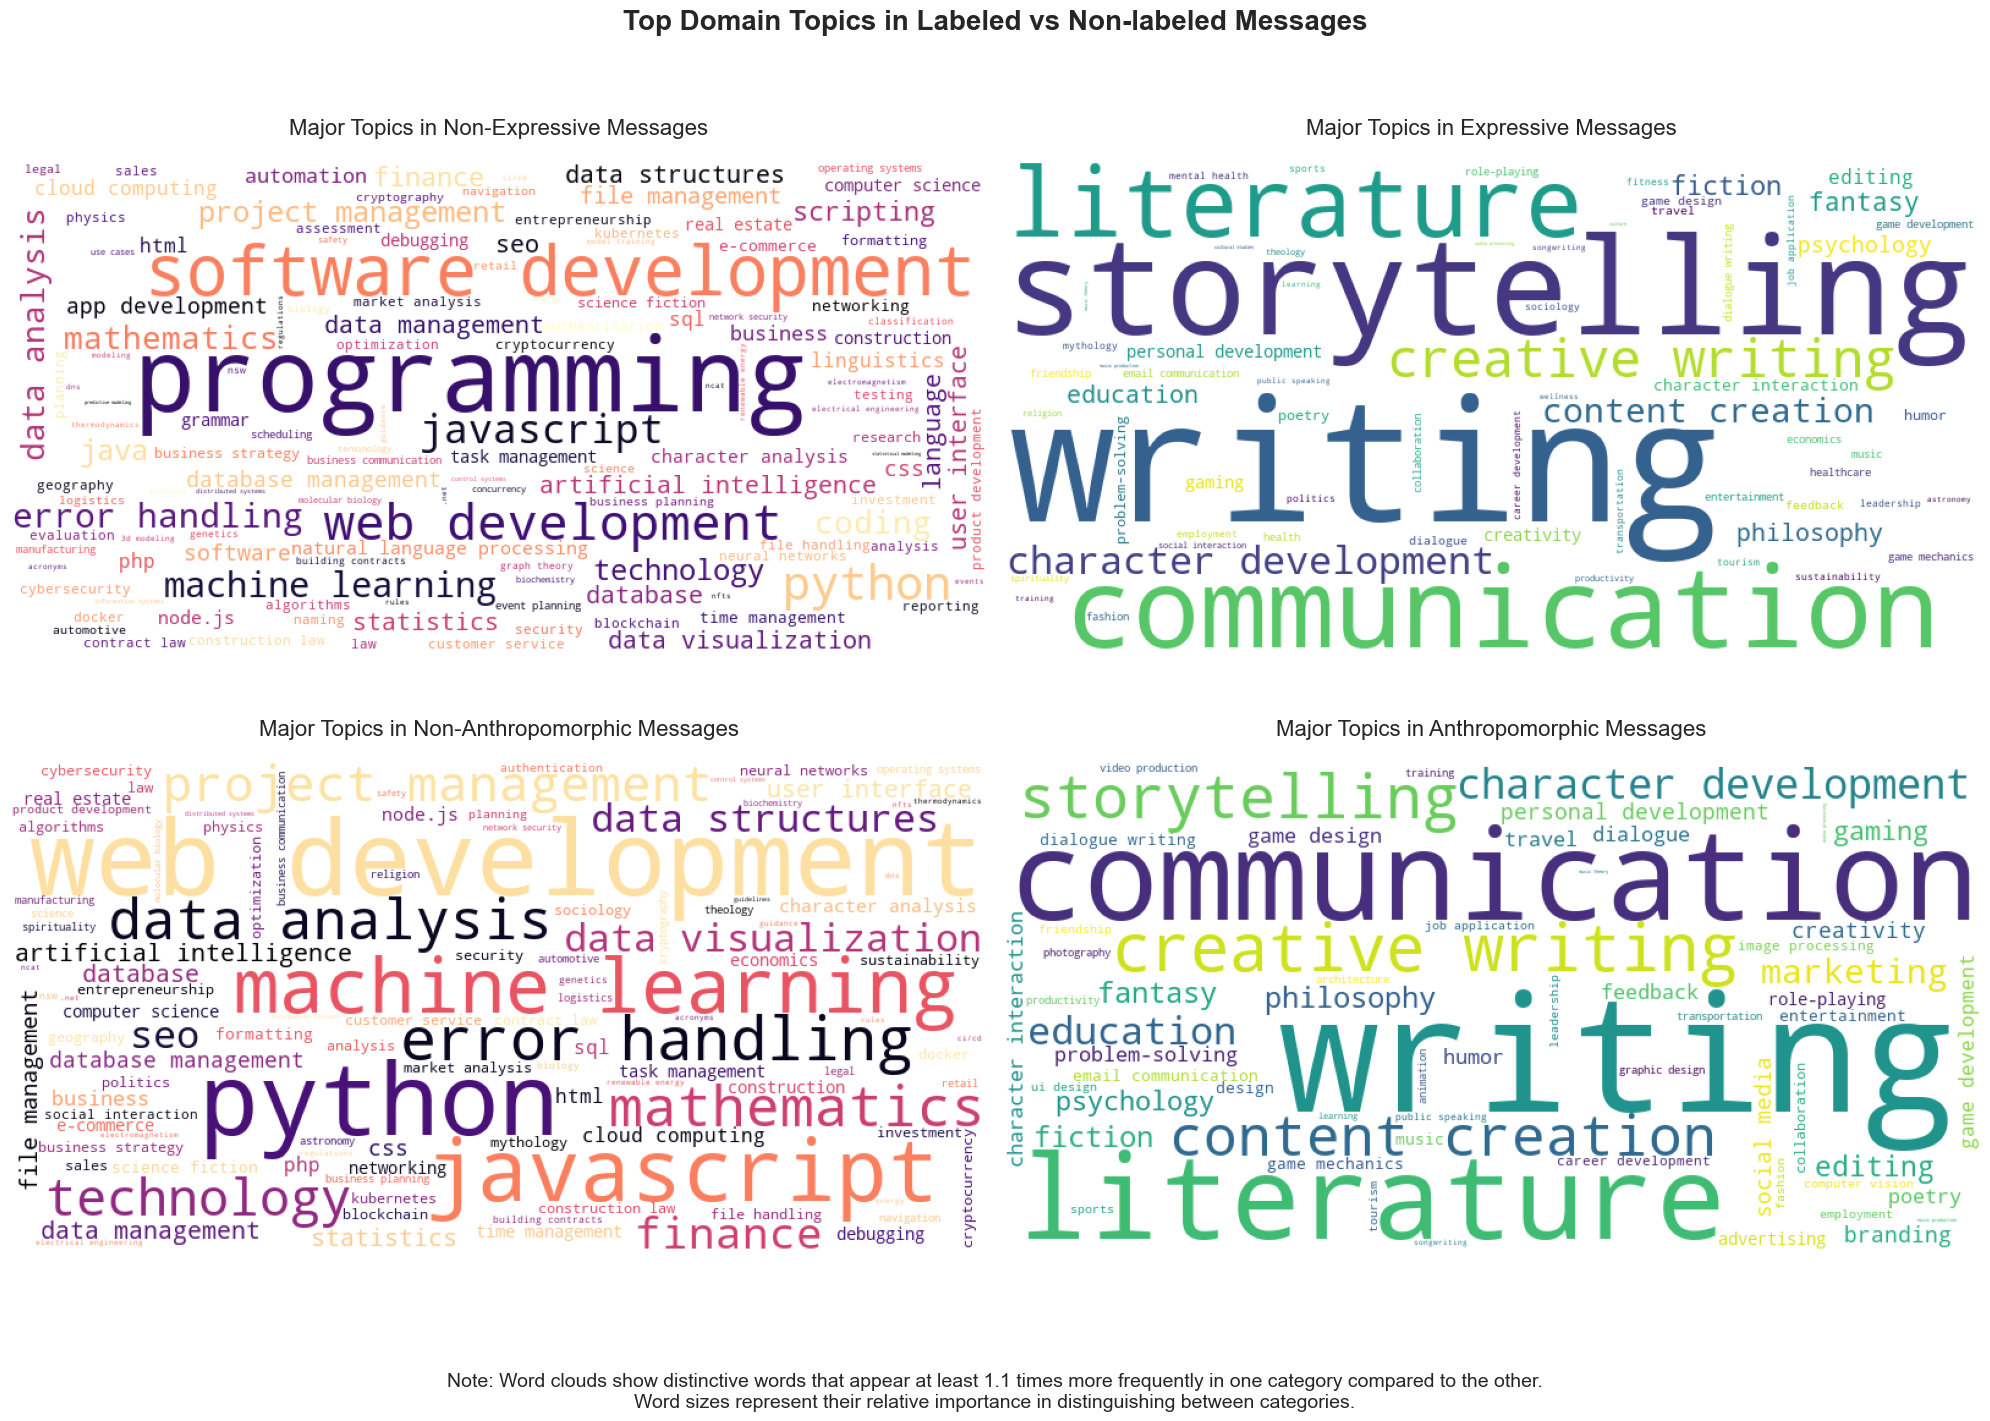

In [73]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_distinctive_words(df, cluster_info_df, label_col, min_diff_ratio=1.1):
    """
    Get distinctive words for each category by comparing relative frequencies
    """
    # Get messages for each label
    yes_messages = df[df[label_col] == 1]
    no_messages = df[df[label_col] == 0]
    
    # Get cluster frequencies for each group
    def get_cluster_freqs(messages):
        all_clusters = []
        for clusters in messages['domain_topic_clusters']:
            all_clusters.extend(clusters)
        return pd.Series(all_clusters).value_counts()
    
    yes_clusters = get_cluster_freqs(yes_messages)
    no_clusters = get_cluster_freqs(no_messages)
    
    # Calculate relative frequencies
    yes_total = yes_clusters.sum()
    no_total = no_clusters.sum()
    
    # Get words and their relative frequencies
    yes_words = {}
    no_words = {}
    
    # Process each cluster
    for cluster_num in set(yes_clusters.index) | set(no_clusters.index):
        cluster_id = f'C{cluster_num}'
        if cluster_id in cluster_info_df['Cluster'].values:
            cluster_words = cluster_info_df[cluster_info_df['Cluster'] == cluster_id]['Top Words (with counts)'].iloc[0]
            
            yes_freq = yes_clusters.get(cluster_num, 0) / yes_total
            no_freq = no_clusters.get(cluster_num, 0) / no_total
            
            for word_count in cluster_words.split(' | '):
                word = word_count.split(' (')[0].lower()
                word_freq = int(word_count.split('(')[1].rstrip(')').replace(',', ''))
                
                if yes_freq > no_freq * min_diff_ratio:
                    yes_words[word] = yes_words.get(word, 0) + (yes_freq * word_freq)
                elif no_freq > yes_freq * min_diff_ratio:
                    no_words[word] = no_words.get(word, 0) + (no_freq * word_freq)
    
    return yes_words, no_words

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Top Domain Topics in Labeled vs Non-labeled Messages', 
             fontsize=20, y=0.95, fontweight='bold')

# Generate word clouds
labels = {
    'expressive_label': 'Expressive',
    'anthropomorphic_label': 'Anthropomorphic'
}

# Read cluster info
cluster_info = pd.read_csv('clustering_results/domain_clusters_detailed.csv')

for idx, (label_col, label_name) in enumerate(labels.items()):
    # Get distinctive words
    yes_words, no_words = get_distinctive_words(df, cluster_info, label_col)
    
    # Create word clouds
    wc_yes = WordCloud(width=800, height=400, 
                      background_color='white',
                      colormap='viridis').generate_from_frequencies(yes_words)
    
    wc_no = WordCloud(width=800, height=400, 
                     background_color='white',
                     colormap='magma').generate_from_frequencies(no_words)
    
    # Plot
    axes[idx, 0].imshow(wc_no)
    axes[idx, 0].axis('off')
    axes[idx, 0].set_title(f'Major Topics in Non-{label_name} Messages', pad=20, fontsize=16)
    
    axes[idx, 1].imshow(wc_yes)
    axes[idx, 1].axis('off')
    axes[idx, 1].set_title(f'Major Topics in {label_name} Messages', pad=20, fontsize=16)

# Add explanatory note
note = """Note: Word clouds show distinctive words that appear at least 1.1 times more frequently in one category compared to the other.
Word sizes represent their relative importance in distinguishing between categories."""

plt.figtext(0.5, 0.02, note, ha='center', fontsize=14, wrap=True)

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.05)

# Print top distinctive words
for label_col, label_name in labels.items():
    print(f"\nTop 20 distinctive words for {label_name}:")
    yes_words, no_words = get_distinctive_words(df, cluster_info, label_col)
    
    print(f"\nDistinctive for {label_name} = Yes:")
    for word, weight in sorted(yes_words.items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {weight:.4f}")
    
    print(f"\nDistinctive for {label_name} = No:")
    for word, weight in sorted(no_words.items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"{word}: {weight:.4f}")

In [76]:
import pandas as pd
import numpy as np

# Define programming-related clusters
prog_clusters = {12, 31, 49, 20, 25, 22}  # removing 'C' prefix, using set for faster lookup

# Count messages that contain any of these clusters
prog_messages = df['domain_topic_clusters'].apply(
    lambda x: any(cluster in prog_clusters for cluster in x)
)

# Calculate counts and percentages
total_messages = len(df)
prog_count = prog_messages.sum()
prog_percentage = (prog_count / total_messages) * 100

print(f"Total messages: {total_messages:,}")
print(f"Messages with programming clusters: {prog_count:,}")
print(f"Percentage: {prog_percentage:.1f}%")

# Break down by individual clusters
cluster_counts = {}
for cluster in prog_clusters:
    count = df['domain_topic_clusters'].apply(lambda x: cluster in x).sum()
    percentage = (count / total_messages) * 100
    cluster_counts[f'C{cluster}'] = {'count': count, 'percentage': percentage}

print("\nBreakdown by cluster:")
for cluster, stats in cluster_counts.items():
    print(f"{cluster}: {stats['count']:,} messages ({stats['percentage']:.1f}%)")

Total messages: 333,939
Messages with programming clusters: 109,377
Percentage: 32.8%

Breakdown by cluster:
C49: 27,814 messages (8.3%)
C20: 22,929 messages (6.9%)
C22: 14,740 messages (4.4%)
C25: 20,365 messages (6.1%)
C12: 42,636 messages (12.8%)
C31: 32,729 messages (9.8%)


In [81]:
import pandas as pd
import numpy as np

# Define programming-related clusters
prog_clusters = {48, 27}

# Identify programming messages
prog_messages = df['domain_topic_clusters'].apply(
    lambda x: any(cluster in prog_clusters for cluster in x)
)

# Split into programming and non-programming messages
prog_df = df[prog_messages]
non_prog_df = df[~prog_messages]

# Calculate metrics
metrics = {
    'Total Messages': len,
    'Expressive Rate': lambda x: x['expressive_label'].mean(),
    'Anthropomorphic Rate': lambda x: x['anthropomorphic_label'].mean(),
    'Average Sentiment': lambda x: x['compound_sentiment'].mean(),
    'Self-Reference Rate': lambda x: x['self_ref_ratio'].mean(),
    'Second-Person Rate': lambda x: x['second_person_ratio'].mean()
}

# Calculate statistics for both groups
prog_stats = {name: func(prog_df) for name, func in metrics.items()}
non_prog_stats = {name: func(non_prog_df) for name, func in metrics.items()}

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Programming Messages': prog_stats,
    'Other Messages': non_prog_stats
})

# Add percentage of total
comparison.loc['Percentage of Dataset'] = [
    len(prog_df) / len(df) * 100,
    len(non_prog_df) / len(df) * 100
]

# Format the results
comparison = comparison.round(3)

print("Comparison of Programming vs Non-Programming Messages:")
print(comparison)

# Perform statistical tests for significance
from scipy import stats

def print_stat_test(metric):
    stat, pval = stats.mannwhitneyu(
        prog_df[metric],
        non_prog_df[metric],
        alternative='two-sided'
    )
    print(f"\n{metric} Mann-Whitney U test:")
    print(f"p-value: {pval:.4e}")
    print("Difference is statistically significant" if pval < 0.05 else "Difference is not significant")

# Test key metrics
print("\nStatistical Tests:")
for metric in ['expressive_label', 'anthropomorphic_label', 'compound_sentiment']:
    print_stat_test(metric)

Comparison of Programming vs Non-Programming Messages:
                       Programming Messages  Other Messages
Total Messages                    47465.000      286474.000
Expressive Rate                       0.296           0.121
Anthropomorphic Rate                  0.303           0.202
Average Sentiment                     0.201           0.179
Self-Reference Rate                   0.019           0.021
Second-Person Rate                    0.019           0.018
Percentage of Dataset                14.214          85.786

Statistical Tests:

expressive_label Mann-Whitney U test:
p-value: nan
Difference is not significant

anthropomorphic_label Mann-Whitney U test:
p-value: nan
Difference is not significant

compound_sentiment Mann-Whitney U test:
p-value: nan
Difference is not significant
